In this notebook, I will show how to use tree-based machine learning models to predict future values of a stock's price, as well as how to use forest-based machine learning methods for regression and feature selection.

### Feature engineering from Volume:

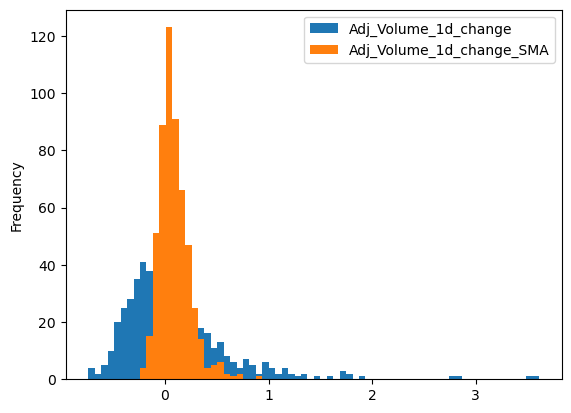

In [32]:
# Creating 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
lng_df['Adj_Volume_1d_change'] = lng_df['Volume'].pct_change(1)
lng_df['Adj_Volume_1d_change_SMA'] = talib.SMA(lng_df['Adj_Volume_1d_change'].values,timeperiod=5)

# Plotting histograms of these two new features we created using the new_features list
lng_df[new_features].plot(kind='hist', sharex=False, bins=70)
plt.show()

In [33]:
# Using pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(lng_df.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = lng_df.index

# Join the dataframe with the days of week dataframe
lng_df = pd.concat([lng_df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
lng_df.dropna(inplace=True)  # drop missing values in-place
print(lng_df.head())

                 Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2020-10-23  50.209999  50.560001  48.310001  48.700001  47.212143   882400   
2020-10-26  48.250000  48.400002  46.540001  47.630001  46.174835  1152500   
2020-10-27  47.639999  49.340000  47.630001  47.889999  46.426891  1915700   
2020-10-28  46.930000  47.720001  45.950001  47.430000  45.980942  1354200   
2020-10-29  46.869999  48.200001  45.509998  48.099998  46.630466  1333700   

            5d_future_close  5d_close_future_pct  5d_close_pct      ma14  ...  \
Date                                                                      ...   
2020-10-23        46.407501            -0.017043     -0.026779  1.005955  ...   
2020-10-26        45.612553            -0.012177     -0.027959  1.030098  ...   
2020-10-27        46.552917             0.002715     -0.038932  1.026832  ...   
2020-10-28        46.746811             0.016656

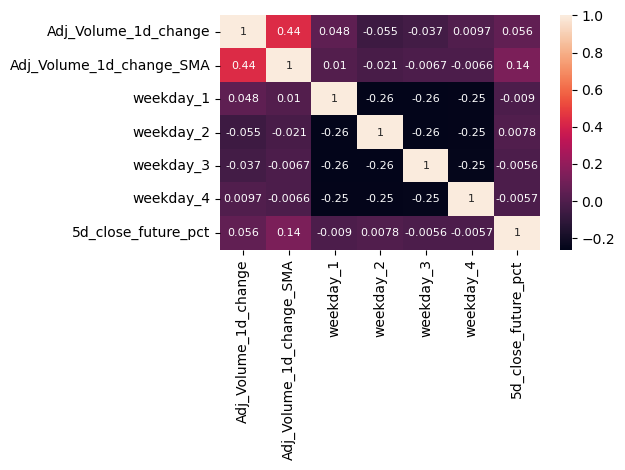

In [34]:
# Adding the weekday labels to the new_features list
new_features.extend(['weekday_' + str(i) for i in range(1, 5)])

# Plotting the correlations between the new features and the targets
sns.heatmap(lng_df[new_features + ['5d_close_future_pct']].corr(), annot=True, annot_kws = {"size": 8})
plt.yticks(rotation=0, size = 10)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90, size = 10)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()

Above, we the correlations between our new features (stored in the new_features list) and the target (5d_close_future_pct) to see how strongly they are related.

### Implementing decision trees:

In [35]:
from sklearn.tree import DecisionTreeRegressor

# Creating a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fitting the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Checking the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

1.0
-1.216467570443856


In [36]:
# Looping through a few different max depths and check the performance
for d in [3, 5, 10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth = d)
    decision_tree.fit(train_features, train_targets)

    # Printing out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features, train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth= 3
0.19720614887339272
-0.24450734931225027 

max_depth= 5
0.4323710813767987
-0.5737347212022106 

max_depth= 10
0.8977652252915427
-1.478827509050928 



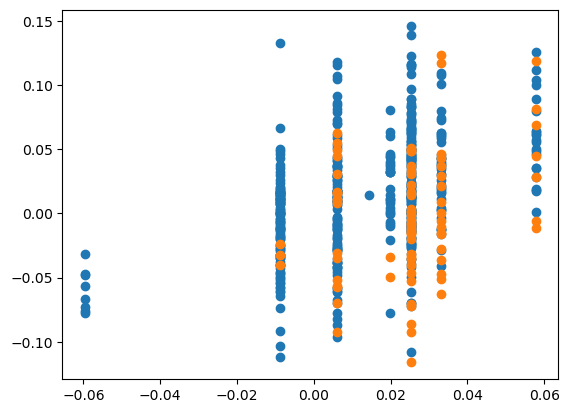

In [37]:
# Using the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth = 3)
decision_tree.fit(train_features, train_targets)

# Predicting values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter plot for the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label = 'test')
plt.show()

## Random Forests

### Fitting a random forest:

In [38]:
from sklearn.ensemble import RandomForestRegressor

# Creating the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.9132745666705213
-0.2996945426807933


### Tuning random forest hyperparameters:

In [39]:
from sklearn.model_selection import ParameterGrid

# Creating a dictionary of hyperparameters to search
grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

# Looping through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Finding best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

-0.21254641714260925 {'random_state': 42, 'n_estimators': 200, 'max_features': 8, 'max_depth': 3}


### Evaluating performance:

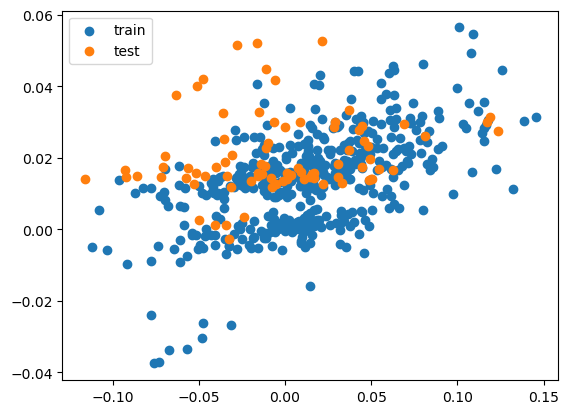

In [40]:
# Using the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Making predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Creating a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

### Random forest feature importances:

* **Feature importances** are a quantitative way to measure how much each feature contributes to our predictions. It allows us to focus on our best features, and remove useless features that may be cluttering up our model.

* Tree models in sklearn have a **.feature_importances_** property that's accessible after fitting the model, which stores the feature importance scores. We use NumPy's **np.argsort()** in order to sort our data in our plot of feature importances (sorted from greatest to least importance).

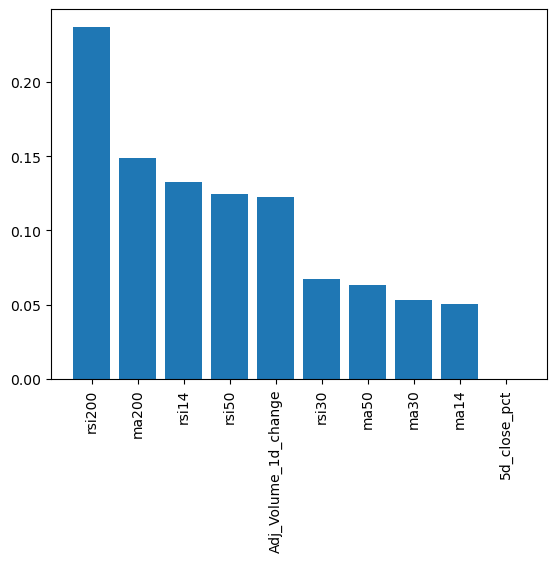

In [41]:
# Getting feature importances from our random forest model
importances = rfr.feature_importances_

# Getting the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Creating tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotating tick labels to vertical
plt.xticks(rotation=90)
plt.show()

### Gradient boosting (GB) model:

* GB is similar to random forest models, but the difference is that trees are built successively. With each iteration, the next tree fits the residual errors from the previous tree in order to improve the fit.

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

# Creating GB model
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.3548086375656694
-0.19812413899222747


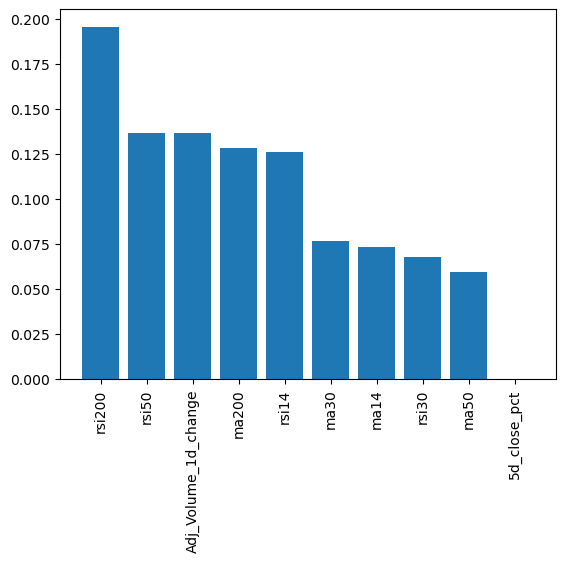

In [44]:
# Extracting feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Getting the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]

# Ensuring the length of x corresponds to the length of feature importances
x = range(len(sorted_index))  # Length must match the sorted indices

# Creating tick labels with the correct shape
labels = np.array(feature_names)[sorted_index]

# Plotting the bar chart
plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Setting the tick labels to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()